# Laboratory Eight

#### Introduction
This laboratory examines how effect repetition codes are in reducing errors. The repetition code that we will use has three qubits, so it is not the best. Start with some import statements and our noise model.

In [7]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import *
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

#### Test Circuit
We will start with the following simple circuit.

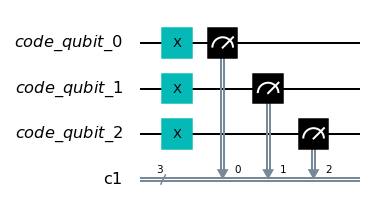

In [11]:
cq = QuantumRegister(3,'code_qubit')
sb = ClassicalRegister(3)
qc = QuantumCircuit(cq,sb)
qc.x(cq[0])
qc.x(cq[1])
qc.x(cq[2])
qc.measure(cq,sb)
qc.draw('mpl')

When we run this circuit with a noise model, we get the following result.

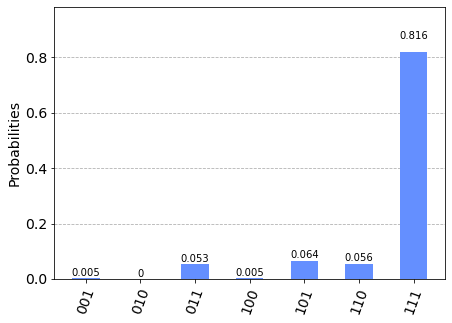

In [12]:
noise_model = get_noise(0.01, 0.1)
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

There clearly is some noise here, but a majority vote will produce the correct result most of the time. Now let’s add the technique that we used in lab six to measure the code qubits to see if they agree. The code for doing this is shown below.

It’s easier to understand what’s going on in terms of the circuit diagram:


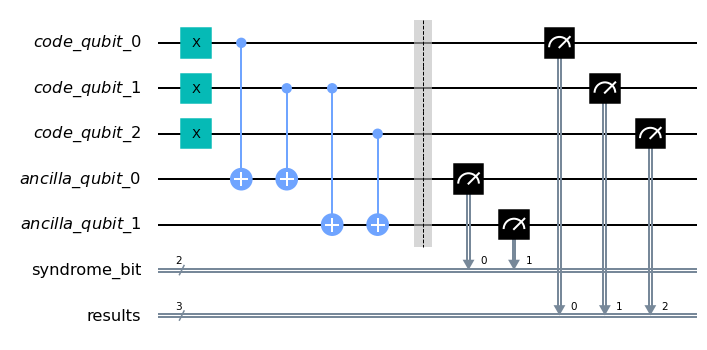

In [13]:
print('It’s easier to understand what’s going on in terms of the circuit diagram:')

cq = QuantumRegister(3,'code_qubit')
lq = QuantumRegister(2,'ancilla_qubit')
sb = ClassicalRegister(2,'syndrome_bit')
rs = ClassicalRegister(3,'results')
qc = QuantumCircuit(cq,lq,sb,rs)
qc.x(cq[0])
qc.x(cq[1])
qc.x(cq[2])
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.cx(cq[1],lq[1])
qc.cx(cq[2],lq[1])
qc.barrier()
qc.measure(lq,sb)
qc.measure(cq,rs)
qc.draw('mpl')

In this circuit we have two sets of qubits and two sets of classical bits. The code qubits are the repetition code and the ancilla qubits are the ones that are monitoring the code qubits. Note that they examine the code qubits pairwise. The first set of classical bits are the syndrome, which is the result of measuring the ancilla bits. These bits tell us if all the code bits have the same value, and if not the one that is incorrect. The final set of classical bits is the result of reading the code qubits. When we run this circuit, we get the following result:

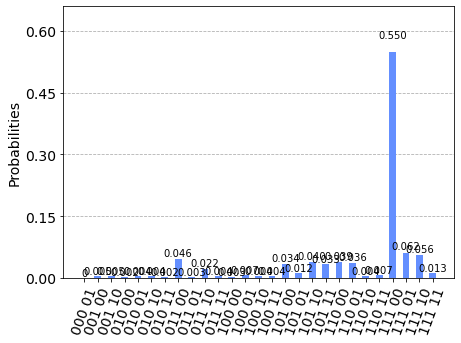

In [14]:
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

This is a lot of information. To see what’s going on let’s just look at the syndrome bits:

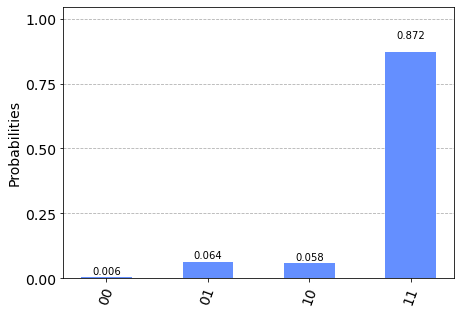

In [23]:
qc = QuantumCircuit(lq,sb)
qc.x(lq[1])
qc.x(lq[0])
qc.measure(lq,sb)
qc.draw('mpl')
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

Here a 00 result indicates that all three of the code qubits have the same value, while the other three results indicate a disagreement between the qubits. We can summarize this in the following table.

| Syndrome Bits | Indication |
| :----------- | :----------- |
|00  |All three code qubits are the same|
|01  |The first code qubit has a different value|
|10  |The third code qubit has a different value|
|11  |The second code qubit has a different value|

We can use this information to attempt to repair the code qubits. Note, this information only tells us that the qubits are different, it doesn’t tell us whether the qubits are correct or not. If one of the qubits are different, we can use an X gate to change the value of that qubit. We can do this with the following Python code.

This code produces the following circuit:


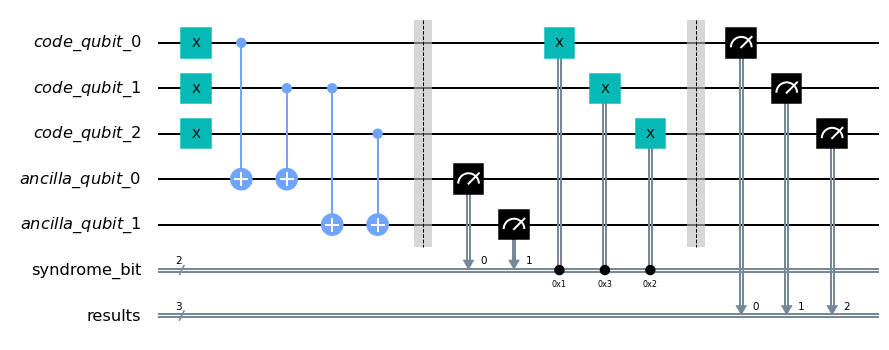

In [28]:
cq = QuantumRegister(3,'code_qubit')
lq = QuantumRegister(2,'ancilla_qubit')
sb = ClassicalRegister(2,'syndrome_bit')
rs = ClassicalRegister(3,'results')
qc = QuantumCircuit(cq,lq,sb,rs)
qc.x(cq[0])
qc.x(cq[1])
qc.x(cq[2])
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.cx(cq[1],lq[1])
qc.cx(cq[2],lq[1])
qc.barrier()
qc.measure(lq,sb)
qc.x(cq[0]).c_if(sb,1)
qc.x(cq[1]).c_if(sb,3)
qc.x(cq[2]).c_if(sb,2)
qc.barrier()
qc.measure(cq,rs)
print('This code produces the following circuit:')
qc.draw('mpl')

When we run this circuit, we get the following:

When we run this circuit, we get the following:


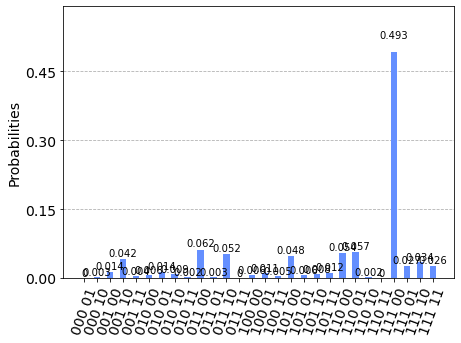

In [26]:
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

Well this is quite a mess. We would have hoped to get a better result. Taking a look at the circuit we see that we have more gates doing error correction than we have gates doing computation! It is far more likely that we will have errors in the error correction part of the circuit that the computational part! So, let’s try 10 X gates instead of one. Note, our expected result is now 000.

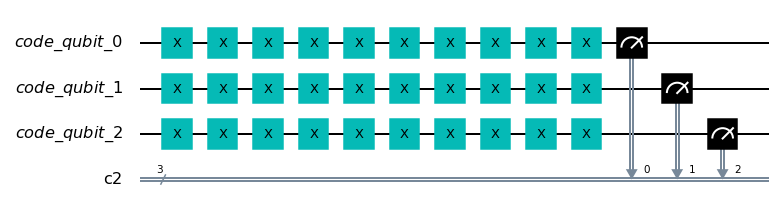

In [29]:
cq = QuantumRegister(3,'code_qubit')
sb = ClassicalRegister(3)
qc = QuantumCircuit(cq,sb)
N = 10
for i in range(N):
    qc.x(cq[0])
    qc.x(cq[1])
    qc.x(cq[2])
qc.measure(cq,sb)
qc.draw('mpl')

When we run this circuit, we get the following result:

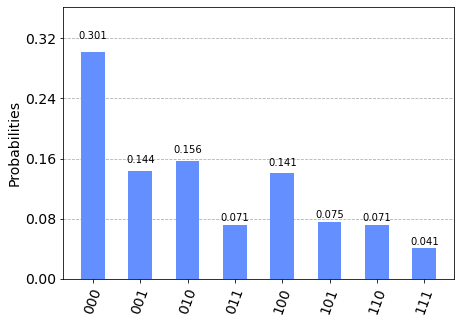

In [30]:
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

That's a lot noiser, so let's now repeat that error correction. We have the following circuit:

This code produces the following circuit:


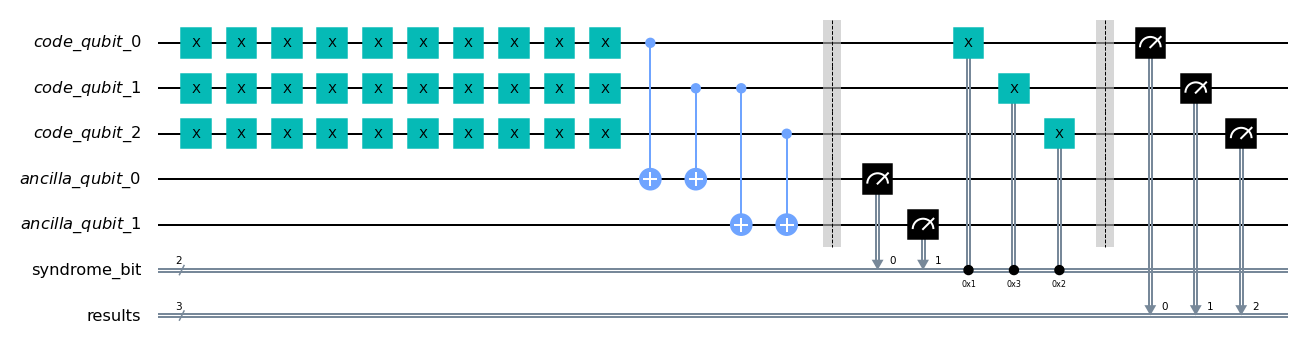

In [31]:
cq = QuantumRegister(3,'code_qubit')
lq = QuantumRegister(2,'ancilla_qubit')
sb = ClassicalRegister(2,'syndrome_bit')
rs = ClassicalRegister(3,'results')
qc = QuantumCircuit(cq,lq,sb,rs)
N = 10
for i in range(N):
    qc.x(cq[0])
    qc.x(cq[1])
    qc.x(cq[2])
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.cx(cq[1],lq[1])
qc.cx(cq[2],lq[1])
qc.barrier()
qc.measure(lq,sb)
qc.x(cq[0]).c_if(sb,1)
qc.x(cq[1]).c_if(sb,3)
qc.x(cq[2]).c_if(sb,2)
qc.barrier()
qc.measure(cq,rs)
print('This code produces the following circuit:')
qc.draw('mpl')

We get the following results when we run the circuit:

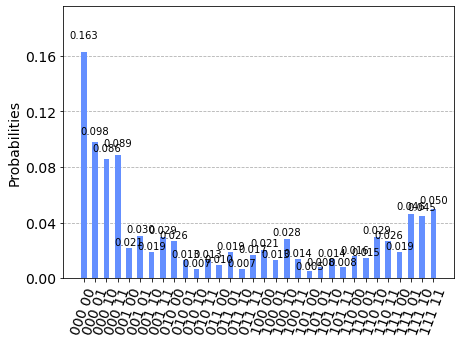

In [32]:
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

This is maybe a bit better, I think. We would need to do a bit of work to total everything up to see if we are getting a better result. These results indicate that a 3 qubit code is probably not good enough, we need to have more qubits in our code. Going to 5 or 7 qubits would probably improve the results. Qiskit has some tools for doing this and performing more sophisticated analysis of the results.
#### Laboratory Activity
If you examine the noise model that we are using a gate error of 0.1, which is quite large. For this laboratory repeat the last part of the experiment with a gate error of 0.01. This involves rerunning the last two circuits with the lower gate error. Cut and paste the two histograms that result from this change into your report for this laboratory. Submit the report as a PDF or PNG file.

# Laboratory Eight
#### Laboratory Activity
If you examine the noise model that we are using a gate error of 0.1, which is quite large. For this laboratory repeat the last part of the experiment with a gate error of 0.01. This involves rerunning the last two circuits with the lower gate error. Cut and paste the two histograms that result from this change into your report for this laboratory. Submit the report as a PDF or PNG file.

#### First Circuit

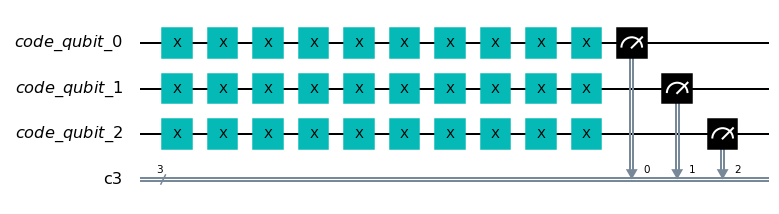

In [34]:
cq = QuantumRegister(3,'code_qubit')
sb = ClassicalRegister(3)
qc = QuantumCircuit(cq,sb)
N = 10
for i in range(N):
    qc.x(cq[0])
    qc.x(cq[1])
    qc.x(cq[2])
qc.measure(cq,sb)
qc.draw('mpl')

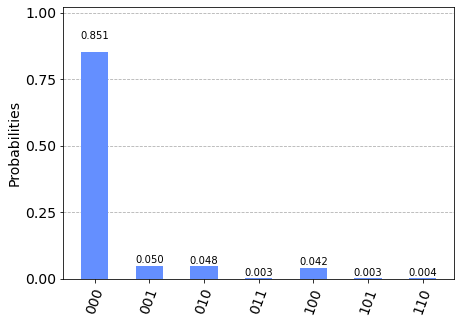

In [35]:
noise_model = get_noise(0.01, 0.01)
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

#### Second Circuit

This code produces the following circuit:


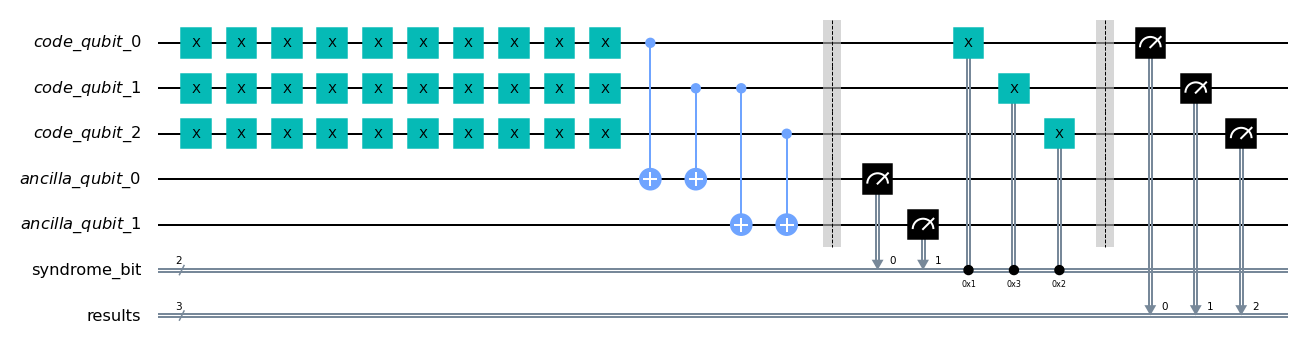

In [36]:
cq = QuantumRegister(3,'code_qubit')
lq = QuantumRegister(2,'ancilla_qubit')
sb = ClassicalRegister(2,'syndrome_bit')
rs = ClassicalRegister(3,'results')
qc = QuantumCircuit(cq,lq,sb,rs)
N = 10
for i in range(N):
    qc.x(cq[0])
    qc.x(cq[1])
    qc.x(cq[2])
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.cx(cq[1],lq[1])
qc.cx(cq[2],lq[1])
qc.barrier()
qc.measure(lq,sb)
qc.x(cq[0]).c_if(sb,1)
qc.x(cq[1]).c_if(sb,3)
qc.x(cq[2]).c_if(sb,2)
qc.barrier()
qc.measure(cq,rs)
print('This code produces the following circuit:')
qc.draw('mpl')

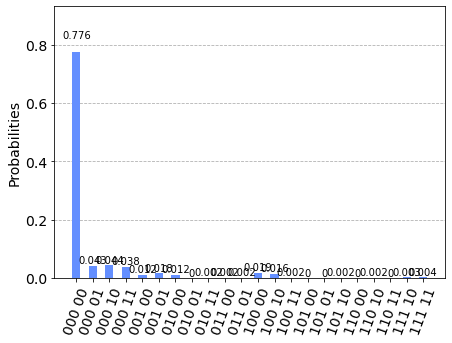

In [33]:
noise_model = get_noise(0.01, 0.01)
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
plot_histogram(counts)